In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm, solve
from matplotlib.patches import Circle

plt.style.use("ggplot")

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


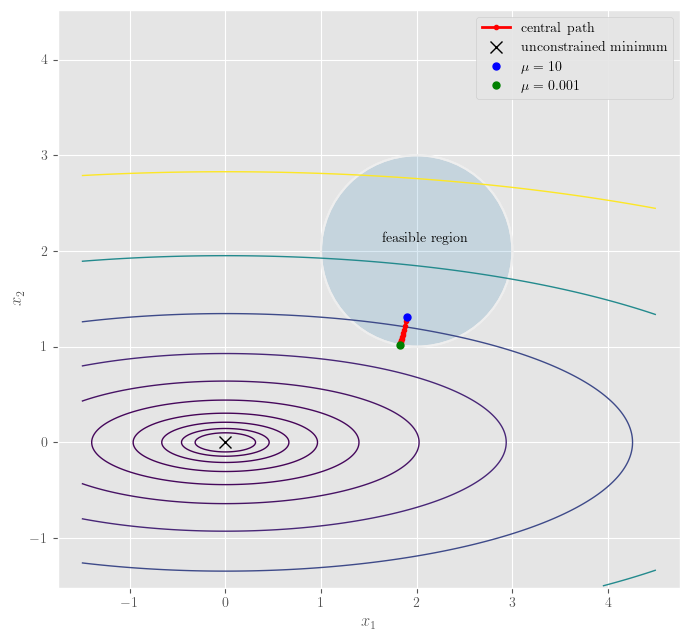

In [ ]:
def f(x):
    return x[0]**2 + 10.0*x[1]**2

def grad_f(x):
    return np.array([2.0*x[0], 20.0*x[1]])

def H_f(x):
    return np.array([[2.0, 0.0],
                     [0.0, 20.0]])

def h(x):
    return 1.0 - (x[0]-2.0)**2 - (x[1]-2.0)**2

def grad_h(x):
    return np.array([-2.0*(x[0]-2.0), -2.0*(x[1]-2.0)])

def H_h(x):
    return np.array([[-2.0, 0.0],
                     [0.0, -2.0]])

def phi(x, mu):
    return f(x) - mu*np.log(h(x))

def grad_phi(x, mu):
    return grad_f(x) - (mu/h(x))*grad_h(x)

def H_phi(x, mu):
    return H_f(x) - (mu/h(x))*H_h(x) + (mu/(h(x)**2)) * np.outer(grad_h(x), grad_h(x))

def newton_minimize_phi(x0, mu, tol=1e-10, max_iter=200):
    x = x0.copy()
    c1 = 1e-4
    beta = 0.5
    for _ in range(max_iter):
        g = grad_phi(x, mu)
        if norm(g) < tol:
            break
        H = H_phi(x, mu)
        try:
            p = -solve(H, g)
        except Exception:
            # In the unlikely event H is singular, take gradient step
            p = -g

        t = 1.0
        # keep inside feasible region
        while h(x + t*p) <= 0.0:
            t *= beta
            if t < 1e-12:
                break
        # sufficient decrease
        while phi(x + t*p, mu) > phi(x, mu) + 1e-4*t*np.dot(g, p):
            t *= beta
            if t < 1e-12:
                break
        x = x + t*p
    return x

x_start = np.array([2.0, 2.0])  # strictly feasible
mus = np.logspace(1.0, -3.0, 35)  # from 10 down to 1e-3
path = []
x = x_start.copy()
for mu in mus:
    x = newton_minimize_phi(x, mu)
    path.append(x.copy())
path = np.array(path)

def constrained_optimum():
    c = np.array([2.0, 2.0])
    Q = np.array([[1.0, 0.0], [0.0, 10.0]])
    lambdas = np.linspace(-0.99, 200.0, 40000)
    best = None
    for lam in lambdas:
        A = Q + lam*np.eye(2)
        try:
            x_candidate = np.linalg.solve(A, lam*c)
        except np.linalg.LinAlgError:
            continue
        if abs(((x_candidate - c) @ (x_candidate - c)) - 1.0) < 1e-5:
            val = f(x_candidate)
            if best is None or val < best[0]:
                best = (val, x_candidate)
    return best[1] if best else None

x_constrained = constrained_optimum()  # approximate

plt.figure(figsize=(7, 6.5))

# objective contours (ellipses)
xx = np.linspace(-1.5, 4.5, 400)
yy = np.linspace(-1.5, 4.5, 400)
X, Y = np.meshgrid(xx, yy)
F = X**2 + 10.0*Y**2
levels = np.geomspace(0.1, 80.0, 10)
plt.contour(X, Y, F, levels=levels, linewidths=1.0)

# feasible region (disk) shaded and boundary drawn
ax = plt.gca()
disk = Circle((2.0, 2.0), 1.0, alpha=0.18, lw=1.5)
ax.add_patch(disk)
circle = Circle((2.0, 2.0), 1.0, fill=False, lw=1.5)
ax.add_patch(circle)

# central path
plt.plot(path[:,0], path[:,1], marker="o", linestyle="-", linewidth=2.0, markersize=3, label="central path", color="red")

# key points
plt.plot([0.0], [0.0], marker="x", markersize=9, linewidth=0, label="unconstrained minimum", color="black")
# plt.plot([2.0], [2.0], marker="s", markersize=7, linewidth=0, label="analytic center")
if x_constrained is not None:
    plt.plot([x_constrained[0]], [x_constrained[1]], marker="*", markersize=10, linewidth=0, label="constrained optimum")

# initial point
plt.plot(path[0,0], path[0,1], marker="o", markersize=5, linewidth=0, label=r"$\mu=10$", color="blue")
# final point
plt.plot(path[-1,0], path[-1,1], marker="o", markersize=5, linewidth=0, label=r"$\mu=0.001$", color="green")

# labels
# plt.annotate("analytic center", (2.0, 2.0), textcoords="offset points", xytext=(6, 6))
if x_constrained is not None:
    plt.annotate("constrained optimum", (x_constrained[0], x_constrained[1]), textcoords="offset points", xytext=(6, 6))
# plt.annotate("central path", (path[-8,0], path[-8,1]), textcoords="offset points", xytext=(10, -14))
plt.annotate("feasible region", (2.0, 2.0), textcoords="offset points", xytext=(6, 6), ha="center")
ax.add_patch(circle)


plt.axis("equal")
plt.xlim(-1.5, 4.5)
plt.ylim(-1.5, 4.5)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
# plt.title("Interior-Point Central Path: Quadratic Objective and Circular Constraint")
plt.grid(True)
plt.legend(loc="upper right", framealpha=0.9)
plt.tight_layout()


pdf_path = '../../../figs/optimization/barrier_example.pdf'
plt.savefig(pdf_path, bbox_inches="tight", transparent=True)
plt.show()